## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape
import pandas as pd
import pandas.util
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
img_size = (200,100)    # width and height of all images (resize, if required)
batch_size = 32  # for training and prediction

In [3]:
test_df = pd.read_pickle("test_easy2_df.pkl")
train_df = pd.read_pickle("train_easy2_df.pkl")
val_df = pd.read_pickle("val_easy2_df.pkl")

In [4]:
def path_to_array(filename, landmarks):
    """ Map a filename to an actual image tensor using image augmentation, one-hot encode label."""
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels = 3)
    # now img is 3 dim array of numbers in {0,..., 255}
    img = tf.cast(img, dtype = tf.float32) / 255. # scale to floating point number in [0,1] EVTL IN [-1,1] skalieren??????
 
    return img, landmarks

In [5]:
def make_dataset(df):
    """ Make a tf dataset of images from a pd data frame of file paths """

    # first, make dataset with just the relevant: path and class
    #print((df['path_landmarks'], df['landmarks']))
    ds_path = tf.data.Dataset.from_tensor_slices((df['image_path'], df['landmarks']))

    # convert to data set with actual images
    ds = ds_path.map(path_to_array)
    ds = ds.batch(batch_size)
    return ds

test_ds  = make_dataset(test_df)
val_ds   = make_dataset(val_df)
train_ds = make_dataset(train_df)
train_ds = train_ds.repeat() # infinitely repeat

In [8]:
# for val in val_ds:
#     print(val)
#val_ds

In [9]:
kernel_size = (3, 3)
pool_size   = (2, 2)
first_filters  = 32
second_filters = 64
third_filters  = 128
dropout_conv  = 0.3
dropout_dense = 0.3

model = tf.keras.models.Sequential() # sequential stack of layers

model.add( BatchNormalization(input_shape = (img_size[1],img_size[0], 3)))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( MaxPooling2D (pool_size = pool_size)) 
model.add( Dropout (dropout_conv))

model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( MaxPooling2D (pool_size = pool_size))
model.add( Dropout (dropout_conv))

model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( MaxPooling2D (pool_size = pool_size))
model.add( Dropout (dropout_conv))

model.add( Flatten())
model.add( Dense (256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.001))) #fully connected layer
model.add( Dropout (dropout_dense))
model.add( Dense (20)) # activation weg weil regressionsproblem
model.add( Reshape ((10,2)))

model.summary()
# draw an image with the layers
# tf.keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 100, 200, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 198, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 196, 32)       9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 194, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 97, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 97, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 95, 64)        1

In [10]:
# define the loss, optimization algorithm and prepare the model for gradient computation 
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = 'MSE', metrics = ['acc']) #loss = MSE

In [41]:
num_train = len(train_df)
EPOCHS = 10

# Callbacks: What should be done during (long) training?
modelfname = "landmarks_easy2.h5"
# Function to store model to file, if validation loss has a new record
# Check always after having seen at least another save_freq examples.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    modelfname, monitor = 'val_loss', mode = 'min', 
    save_best_only = True, verbose = 1)

# Function to decrease learning rate by 'factor'
# when there has been no significant improvement in the last 'patience' epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', mode = 'min', factor = 0.75, patience = 4, verbose = 1)
                         
# fit_generator is like fit, but training set generation (image reading) is run in parallel to optimization
history = model.fit_generator(
    train_ds, epochs = EPOCHS, 
    steps_per_epoch = num_train / batch_size, #would use each example once on average
    validation_data = val_ds, verbose = 1,
    callbacks = [checkpoint, reduce_lr])

131/131 [============================>.] - ETA: 1s - loss: 992.9130 - acc: 0.9098 
Epoch 00001: val_loss improved from inf to 416.00392, saving model to landmarks.h5
132/131 [==============================] - 2280s 17s/step - loss: 986.4956 - acc: 0.9098 - val_loss: 416.0039 - val_acc: 1.0000


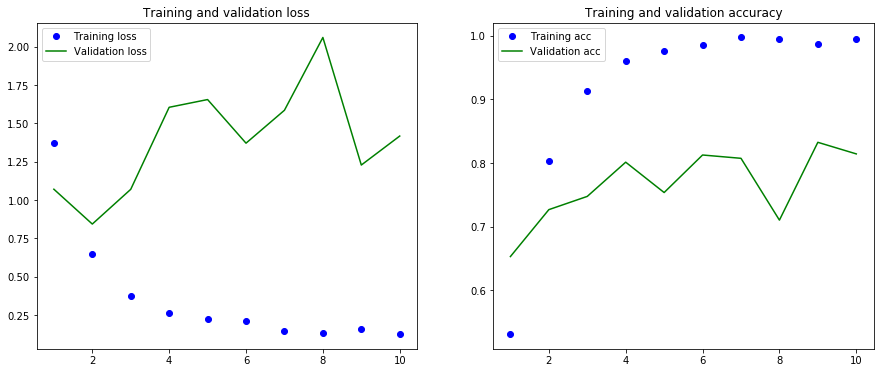

In [20]:
# plot the training history as loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

_, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
ax[0].plot(epochs, val_loss, 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label = 'Training acc')
ax[1].plot(epochs, val_acc, 'g', label = 'Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].legend();

In [42]:
# Load the parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model.load_weights(modelfname)

test_loss, test_acc = model.evaluate(test_ds, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Loss on test set: 408.63048553466797 
Accuracy on test set: 1.0
